## Main Function LINES

- Vehicle part comes in later as list of relevant Cells + Polylines for plot

### Libraries Import 

In [5]:
import time
import math 
import pandas as pd
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import LineString, MultiLineString
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap  # Ensure this line is included
import mapclassify


#### Add Data (Module 1)

In [6]:
def read_and_project_transport_data(gdf, line_numbers=None, crs='EPSG:28992', transport_type=None):
    """
    Reads public transport data from a shapefile, optionally filters by line numbers and transport type,
    and reprojects it to a specified CRS.

    Parameters:
        filepath (str): Path to the shapefile.
        crs (str): Coordinate Reference System to project the data to. Default is 'EPSG:32633'.
        line_numbers (int, list, tuple, or None): Line numbers to filter the data by. Default is None (no filtering).
        transport_type (str, list, or None): Transport type(s) to filter the data by. Default is None (no filtering).

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame containing the projected transport data.
    """
    
    # Apply filtering based on line_numbers if provided
    if line_numbers is not None:
        if isinstance(line_numbers, (list, tuple)):
            gdf = gdf[gdf["route_shor"].isin(line_numbers)]
        elif isinstance(line_numbers, str): #int):
            gdf = gdf[gdf["route_shor"] == line_numbers]
        else:
            raise ValueError("line_numbers must be an int, list, or tuple")
    
    #Apply filtering based on transport_type if provided
    if (transport_type is not None) and (line_numbers is None):
    #if transport_type is not None:
        if isinstance(transport_type, list):
            gdf = gdf[gdf["route_type"].isin(transport_type)]
        elif isinstance(transport_type, int):
            gdf = gdf[gdf["route_type"] == transport_type]
        else:
            raise ValueError("transport_type must be a str or list of str")

    # Reproject to the specified CRS
    gdf_projected = gdf.to_crs(crs)

    return gdf_projected
    

In [7]:
def calculate_buffer(gdf, buffer_distance, crs='EPSG:28992'):
    """
    Calculates a buffer around each geometry in the GeoDataFrame.

    Parameters:
        gdf (gpd.GeoDataFrame): GeoDataFrame with the geometries to buffer.
        buffer_distance (float): Buffer distance in meters. Default is 100 meters.
        crs (str): Coordinate Reference System to use for buffering. Default is 'EPSG:3857' (meters).

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame containing the buffered geometries.
    """
    # Reproject to a CRS that uses meters for distance calculations
    gdf_meters = gdf.to_crs(crs)
    
    # Create a buffer around each geometry
    gdf_meters['geometry'] = gdf_meters['geometry'].buffer(buffer_distance)
    
    return gdf_meters

#### Add Intersections etc. (Module 2)

In [8]:
def spatial_join_and_remove_duplicates(cbs_gdf, buffered_lines, how='inner', predicate='intersects'):
    """
    Performs a spatial join to find intersecting geometries between CBS and transport data, and removes duplicates.

    Parameters:
        cbs_gdf (gpd.GeoDataFrame): GeoDataFrame containing CBS data.
        trams_gdf (gpd.GeoDataFrame): GeoDataFrame containing transport data.
        how (str): Type of join. Default is 'inner'.
        predicate (str): Spatial predicate to use for the join. Default is 'intersects'.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame containing the result of the spatial join with duplicates removed.
    """
    # Ensure both GeoDataFrames have the same CRS
    if cbs_gdf.crs != buffered_lines.crs:
        buffered_lines = buffered_lines.to_crs(cbs_gdf.crs)
    
    # Perform spatial join
    joined_gdf = gpd.sjoin(cbs_gdf, buffered_lines, how=how, predicate=predicate)

    joined_gdf = joined_gdf.drop_duplicates(subset='crs28992', keep='first')  # Keep the first occurrence and remove others
    
    return joined_gdf

#### Add Statistics City etc. (Module 3)

In [9]:
def generate_summary_statistics(cbs_gdf, area_name='Amsterdam'):
    """
    Calculates summary statistics from the CBS GeoDataFrame, excluding specified columns,
    and formats the results into a summary DataFrame.

    Parameters:
        cbs_gdf (gpd.GeoDataFrame): GeoDataFrame containing CBS data.

    Returns:
        pd.DataFrame: A DataFrame containing the summary statistics.
    """
    # Calculate the sum for numeric columns excluding 'G_woz_woni' and 'geometry'
    sum_values = cbs_gdf.drop(columns=['geometry', 'G_woz_woni']).sum()
    
    # Calculate the average for 'G_woz_woni'
    average_woz_woni = cbs_gdf['G_woz_woni'].mean()
    
    # Round the sums and average to zero decimal places
    rounded_sum_values = sum_values.round(0)
    rounded_average_woz_woni = round(average_woz_woni, 0)
    
    # Create the summary row DataFrame
    summary_row_ams = pd.DataFrame({
        'Area': [area_name],
        'A_inhab': [rounded_sum_values.get('A_inhab', 0)],
        'A_0_15': [rounded_sum_values.get('A_0_15', 0)],
        'A_15_25': [rounded_sum_values.get('A_15_25', 0)],
        'A_25_45': [rounded_sum_values.get('A_25_45', 0)],
        'A_45_65': [rounded_sum_values.get('A_45_65', 0)],
        'A_65+': [rounded_sum_values.get('A_65+', 0)],
        'G_woz_woni': [rounded_average_woz_woni],
        'A_nederlan': [rounded_sum_values.get('A_nederlan', 0)],
        'A_west_mig': [rounded_sum_values.get('A_west_mig', 0)],
        'A_n_west_m': [rounded_sum_values.get('A_n_west_m', 0)],
    })

    summary_row_ams['A_inhab'] = summary_row_ams['A_inhab'].astype(int)
    summary_row_ams['G_woz_woni'] = summary_row_ams['G_woz_woni'].astype(int)

    return summary_row_ams

In [10]:
def concatenate_dataframes(dfs, ignore_index=True):
    """
    Concatenates a list of DataFrames into a single DataFrame.

    Parameters:
        dfs (list of pd.DataFrame): List of DataFrames to concatenate.
        ignore_index (bool): Whether to ignore the index and reset it in the resulting DataFrame.

    Returns:
        pd.DataFrame: A single DataFrame resulting from the concatenation of the input DataFrames.
    """
    # Concatenate the DataFrames
    merged_df = pd.concat(dfs, ignore_index=ignore_index)
    
    return merged_df


In [11]:
def calculate_and_compare_sums(cbs_gdf, sensed_gdf):
    """
    Calculates and compares the sums of columns for two GeoDataFrames, and computes the percentage
    of the sensed values relative to the city's total values.

    Parameters:
        cbs_gdf (gpd.GeoDataFrame): GeoDataFrame containing the full city's data.
        sensed_gdf (gpd.GeoDataFrame): GeoDataFrame containing the sensed data.

    Returns:
        pd.DataFrame: A DataFrame containing the sums for both datasets and the percentage of sensed values.
    """
    # Calculate the sum of all columns except 'G_woz_woni', 'geometry', 'index_right', and 'Lijn_Numbe' for the city-wide data
    cbs_sums = cbs_gdf.drop(columns=['crs28992', 'G_woz_woni', 'geometry', 'age_sum','migration_']).sum()
    
    # Extract values from the Series
    values_t = cbs_sums.values

    # Calculate the sum of all columns except 'G_woz_woni', 'geometry', 'index_right', and 'Lijn_Numbe' for the sensed data
    sensed_sums = sensed_gdf.drop(columns=['crs28992', 'G_woz_woni', 'geometry', 'index_right', 'route_type','route_shor', 'route_id', 'shape_id', 'agency_id','age_sum','migration_']).sum() 				
    
    # Extract values from the Series
    values_s = sensed_sums.values

    # Extract keys (index) from the Series
    keys = sensed_sums.index

    # Create a new DataFrame
    data = {
        'Sociodemo': keys,
        'Sums_sensed': values_s,
        'Sums_total': values_t
    }

    sums = pd.DataFrame(data)
    
    # Calculate the percentage of sensed values relative to the city's total values
    sums['Sensed_%'] = ((sums['Sums_sensed'] / sums['Sums_total']) * 100).round(2)
    # Calculate exclusion
    sums['Excluded!'] = (sums['Sums_total'] - sums['Sums_sensed']).round(0)


    # Convert sums to integer values for cleaner display
    sums['Sums_sensed'] = sums['Sums_sensed'].astype(int)
    sums['Sums_total'] = sums['Sums_total'].astype(int)
    sums['Sensed_%'] = sums['Sensed_%'].astype(float)
    sums['Excluded!'] = sums['Excluded!'].astype(int)
    
    return sums

In [12]:
def normalize_statistics(merged_df):
    """
    Normalizes the columns in the merged_statistics DataFrame based on 'A_inhab'.
    Drops 'A_woning' and 'A_inhab', and rounds the results to two decimal places. Get percentages!
    
    Parameters:
        merged_statistics (pd.DataFrame): The DataFrame containing the statistics to normalize.

    Returns:
        pd.DataFrame: A DataFrame with normalized statistics.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    average_stats = merged_df.copy()


    # Identify columns to normalize
    columns_to_normalize = average_stats.columns.difference(['Area', 'G_woz_woni', 'A_inhab'])

    # Normalize the identified columns
    average_stats[columns_to_normalize] = average_stats[columns_to_normalize].div(average_stats['A_inhab'], axis=0)

    # Drop the 'A_inhab' column
    average_stats = average_stats.drop(columns=['A_inhab'])

    # Round to two decimal places
    average_stats = average_stats.round(4)

    return average_stats

### Data Visualization

In [13]:
def plot_stacked_sums(df, buffer_distance):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import AutoMinorLocator


    # change names in Sociodemo to Total Pop, Age < 15, Age 15 - 25, Age 25 - 45, Age 45 - 65, Mig. Dutch, Mig. Western, Mig. Non-Western
    df['Sociodemo'] = df['Sociodemo'].replace({
    'A_inhab': 'Total Pop',
    'A_0_15': 'Age < 15',
    'A_15_25': 'Age 15 - 25',
    'A_25_45': 'Age 25 - 45',
    'A_45_65': 'Age 45 - 65',
    'A_65+': 'Age > 65',
    'A_nederlan': 'Mig. Dutch',
    'A_west_mig': 'Mig. Western',
    'A_n_west_m': 'Mig. Non-Western'
        })


    plt.style.use('default')  # normal theme
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.6
    idx = range(len(df))

    # horizontal grid: major and extra minor lines
    ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # 5 minor intervals
    ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.5)

    # Stacked bars
    ax.bar(idx,
           df['Sums_sensed'],
           bar_width,
           label='Pop Sensed',
           color='#85b66f')
    ax.bar(idx,
           df['Sums_total'] - df['Sums_sensed'],
           bar_width,
           bottom=df['Sums_sensed'],
           label='Pop Unsensed',
           color='#ffa3c4')

    # Annotate Sensed_% at bottom
    for i, pct in enumerate(df['Sensed_%']):
        ax.text(i, 0, f"{pct:.1f}%",
                ha='center', va='bottom', fontweight='normal')

    # styling
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)

    # labels
    ax.set_xticks(idx)
    ax.set_xticklabels(df['Sociodemo'], rotation=45,  fontsize=8.5,ha='right', fontweight='bold')
    ax.set_xlabel('Population Groups', fontweight='bold')
    ax.set_ylabel('Inhabitants', fontweight='bold')
    ax.legend(loc='upper right')
    plt.title(f'Public Transport Sensing {buffer_distance}m buffer', fontweight='bold')
    plt.tight_layout()
    plt.savefig('stacked_sums_plot.png', bbox_inches='tight')
    plt.show()


In [14]:
def plot_transport_and_population(lines, cbs_gdf, sensed_gdf, ams_gdf, buffer_distance, transport_type=None, lijn=None):
    """
    Plots public transport data, CBS population data, and sensed population with a buffer on a map.
    
    Parameters:
        lines (gpd.GeoDataFrame): GeoDataFrame containing the buffered transport data.
        cbs_gdf (gpd.GeoDataFrame): GeoDataFrame containing the CBS data.
        sensed_gdf (gpd.GeoDataFrame): GeoDataFrame containing the sensed data.
        ams_gdf (gpd.GeoDataFrame): GeoDataFrame containing the boundary of the area to plot.
        buffer_distance (float): Distance used for buffering the transport data.
    """

    ams_gdf = gpd.read_file("gemeente_T.shp")
    ams_gdf.crs = "EPSG:28992"
    ams_gdf = ams_gdf.to_crs("EPSG:28992")
 
    # Filter by transport type if provided
    if transport_type is not None:
        if isinstance(transport_type, list):
            lines = lines[lines["route_type"].isin(transport_type)]
        elif isinstance(transport_type, str):
            lines = lines[lines["route_type"] == transport_type]
        else:
            raise ValueError("transport_type must be a str or list of str")
    
    # Filter by line numbers if provided
    if lijn is not None:
        if isinstance(lijn, list):
            lines = lines[lines["route_shor"].isin(lijn)]
        elif isinstance(lijn, int):
            lines = lines[lines["route_shor"] == lijn]
        else:
            raise ValueError("lijn must be an int or list of int")

    # Change projection
    lines = lines.to_crs(ams_gdf.crs)
    cbs_gdf = cbs_gdf.to_crs(ams_gdf.crs)
    sensed_gdf = sensed_gdf.to_crs(ams_gdf.crs)
    
    # Set up the plot with a dark background
    plt.style.use('default')

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))
    
    
    # Plot the boundary
    ams_gdf.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')

    
    # Plot the CBS population
    cbs_gdf.plot(ax=ax, markersize=5, color='#e15989', edgecolor='white', linewidth=0.35)
    
    # Plot the sensed population
    sensed_gdf.plot(ax=ax, markersize=5, color='#85b66f', edgecolor='white', linewidth=0.35)

    # Plot the buffered trams on top
    lines.plot(ax=ax,color='black')  # Adjust linewidth as needed
    
    # Add title and labels
    ax.set_title(f'Public Transport Sensing {buffer_distance}m Buffer', fontweight='bold', fontsize=12)
    
    # Remove X and Y axes
    ax.set_axis_off()
    
    # Create custom legend handles
    line_handle = mlines.Line2D([], [], color='black', linestyle='-', linewidth=2, label='Lines')
    red_dot = mlines.Line2D([], [], color='#e15989', marker='o', markersize=5, linestyle='None', label='Pop Cells')
    green_dot = mlines.Line2D([], [], color='#85b66f', marker='o', markersize=5, linestyle='None', label='Sensed PopCells')
    
    # Add legend
    ax.legend(handles=[line_handle, red_dot, green_dot], loc='upper right')

    # Show plot

    plt.show()
    
    # Save plot as PNG
    #plt.savefig('transport_population_plot.png', bbox_inches='tight')
    #plt.close(fig)


In [15]:
def plot_comparison_difference(average_stats):
    """
    Plots the absolute difference in percentage points between Amsterdam and Sensed Area.
    """
    # prepare
    df = average_stats.drop(columns=['G_woz_woni'], errors='ignore')
    df_melted = df.melt(id_vars='Area', var_name='Metric', value_name='Value')
    df_pivot = df_melted.pivot_table(index='Metric', columns='Area', values='Value')

    # compute percentage‐point difference (pp)
    df_pivot['Difference (pp)'] = (
        df_pivot['Sensed Area'] - df_pivot['Amsterdam']
    ).round(4) * 100

    df_result = df_pivot.reset_index()

    # reorder so 'A_n_west_m' is last
    order = [m for m in df_result['Metric'] if m != 'A_n_west_m'] + ['A_n_west_m']
    df_result['Metric'] = pd.Categorical(df_result['Metric'], categories=order, ordered=True)
    df_result = df_result.sort_values('Metric')

    # custom labels
    x_labels = [
        'Age <15', 'Age 15-25', 'Age 25-45',
        'Age 45-65', 'Age >65',
        'Mig. Dutch', 'Mig. Western', 'Mig. Non‑Western'
    ]

    # plot
    plt.figure(figsize=(14, 6))
    ax = plt.gca()

    ax.axhline(0, color='#ffa3c4', linestyle='--', linewidth=3, zorder=1)
    ax.scatter(
        df_result['Metric'],
        df_result['Difference (pp)'],
        color='#85b66f',
        s=150,
        marker='o',
        label='Pop Sensed',
        zorder=2
    )

    ax.set_xlabel('Population Groups', fontweight='bold')
    ax.set_ylabel('Difference (pp)', fontweight='bold')
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, fontsize=8.5, ha='right', fontweight='bold')

    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.legend()
    ax.text(len(x_labels) - 1, 0, 'City Average', fontsize=10, ha='center', va='bottom', fontweight='bold')

    plt.title('Difference in Percentage Points: Sensed Area Stats vs City Stats', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()

In [16]:


def plot_pie_charts(average_stats, filename=None):
    """
    Plots two sets of pie charts for different metrics: one for age groups and one for ethnic composition.
    Top row: age groups. Bottom row: ethnic composition.
    """
    df = average_stats

    # Extract data for Amsterdam and Sensed Area
    amsterdam_data = df[df['Area'] == 'Amsterdam']
    sensed_area_data = df[df['Area'] == 'Sensed Area']

    # Data columns
    age_columns = ['A_0_15', 'A_15_25', 'A_25_45', 'A_45_65', 'A_65+']
    ethnic_columns = ['A_nederlan', 'A_west_mig', 'A_n_west_m']

    # Display labels
    age_labels = ['Age <15', 'Age 15-25', 'Age 25-45', 'Age 45-65', 'Age >65']
    ethnic_labels = ['Mig. Dutch', 'Mig. Western', 'Mig. Non‑Western']

    # Color schemes (70% opacity)
    ams_age_colors = ['#ffa3c4B3', '#ff85b1B3', '#ff679fB3', '#ff4a8dB3', '#ff2c7bB3']
    ams_eth_colors = ['#ffa3c4B3', '#ff85b1B3', '#ff679fB3']
    sa_age_colors = ['#85b66fB3', '#73a362B3', '#619055B3', '#4f7d47B3', '#3c6a3aB3']
    sa_eth_colors = ['#85b66fB3', '#73a362B3', '#619055B3']

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Amsterdam - Age
    axs[0, 0].pie(
        amsterdam_data[age_columns].values[0],
        labels=age_labels,
        autopct='%1.1f%%',
        colors=ams_age_colors
    )
    axs[0, 0].set_title('City - Age Groups', fontweight='bold')

    # Sensed Area - Age
    axs[0, 1].pie(
        sensed_area_data[age_columns].values[0],
        labels=age_labels,
        autopct='%1.1f%%',
        colors=sa_age_colors
    )
    axs[0, 1].set_title('Sensed Area - Age Groups', fontweight='bold')

    # Amsterdam - Ethnic
    axs[1, 0].pie(
        amsterdam_data[ethnic_columns].values[0],
        labels=ethnic_labels,
        autopct='%1.1f%%',
        colors=ams_eth_colors
    )
    axs[1, 0].set_title('City - Migration Groups', fontweight='bold')

    # Sensed Area - Ethnic
    axs[1, 1].pie(
        sensed_area_data[ethnic_columns].values[0],
        labels=ethnic_labels,
        autopct='%1.1f%%',
        colors=sa_eth_colors
    )
    axs[1, 1].set_title('Sensed Area - Migration Groups', fontweight='bold')

    #plt.tight_layout()
    #if filename:
    #plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


## Master Function Analysis


- transport_filepath: "data/public_transport.gpkg"
- cbs_filepath: "cbs_full.shp"
- buffer_distance: 50


In [17]:
def lines_analysis(transport_gdf, cbs_gdf, buffer_distance = 50, line_number=None, transport_type=None, crs='EPSG:28992'):
    """
    Master pipeline for processing transport and CBS data.

    Parameters:
    - transport_filepath : path to transport data file
    - cbs_filepath : path to CBS shapefile
    - buffer_distance : buffer size in meters
    - line_number : specific line number(s) to filter (optional)
    - transport_type : filter by transport mode (optional)
    - crs : coordinate reference system for processing (default 'EPSG:28992')

    Returns:
    - sums_df : DataFrame comparing sums between total and sensed areas
    - gdf_projected : filtered and projected transport GeoDataFrame
    - cbs_gdf : CBS GeoDataFrame
    - joined_gdf : CBS joined with transport buffer
    - average_stats : normalized summary statistics
    """

    # Step 1: Read and project transport data
    gdf_projected = read_and_project_transport_data(
        transport_gdf,
        line_numbers=line_number,
        crs=crs,
        transport_type=transport_type
    )

    # Step 2: Calculate buffer
    gdf_meters = calculate_buffer(gdf_projected, buffer_distance, crs)

    # Step 4: Perform spatial join
    joined_gdf = spatial_join_and_remove_duplicates(cbs_gdf, gdf_meters)

    # Step 5: Generate summary statistics
    stats_ams = generate_summary_statistics(cbs_gdf)
    stats_sensed = generate_summary_statistics(joined_gdf, 'Sensed Area')

    # Step 6: Concatenate summary statistics
    summary_df = concatenate_dataframes([stats_ams, stats_sensed])

    # Step 7: Calculate and compare sums
    sums_df = calculate_and_compare_sums(cbs_gdf, joined_gdf)

    # Step 8: Normalize statistics
    average_stats = normalize_statistics(summary_df)

    return sums_df, gdf_meters, cbs_gdf, gdf_projected, joined_gdf, average_stats


## Master Function Visualisations

In [18]:
def lines_visualisation(gdf_projected, cbs_gdf, joined_gdf, ams_gdf, sums_df, average_stats, buffer_distance = 50, transport_type=None, line_number=None):
    """
    Master function for visualizing data comparisons.

    """
    # Plot the map
    fig1 = plot_transport_and_population(gdf_projected, cbs_gdf, joined_gdf, ams_gdf, buffer_distance, transport_type=None)
    
    # Plot sums and percentages stacked
    fig2 = plot_stacked_sums(sums_df, buffer_distance)
    
    # Plot pp difference
    fig3 = plot_comparison_difference(average_stats)

    # Plot pie chart comaprison 
    fig4 = plot_pie_charts(average_stats)

    return fig1, fig2, fig3, fig4


## FUNCTION 1 2 | MASTER

In [19]:
# Set parameters 
ams_gdf = gpd.read_file("gemeente_T.shp") # for specific area city
transport_gdf = gpd.read_file("data/public_transport.gpkg", driver="GPKG")
cbs_gdf = gpd.read_file("cbs_full.shp", driver="ESRI Shapefile")
# buffer_distance
buffer_distance = 50  # Buffer distance in meters


c:\Users\pkoljensic\OneDrive - Delft University of Technology\Desktop\PYTHON\projects\sensing\sensing_env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(
c:\Users\pkoljensic\OneDrive - Delft University of Technology\Desktop\PYTHON\projects\sensing\sensing_env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DRIVER
  return ogr_read(


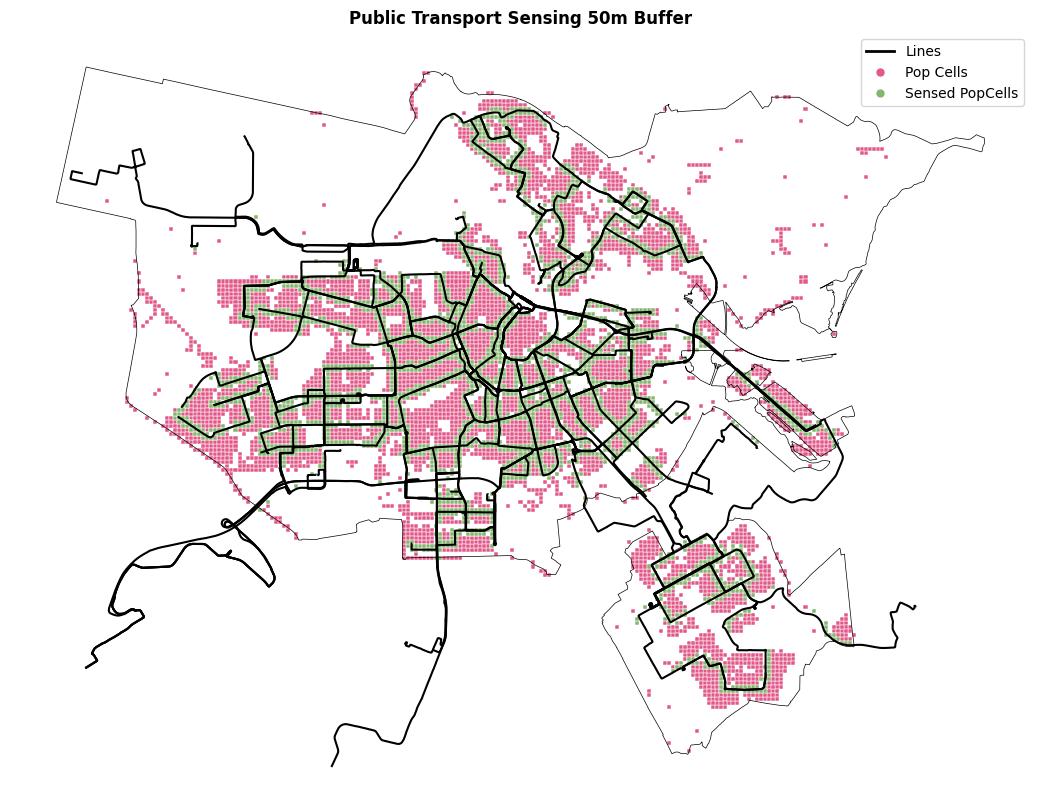

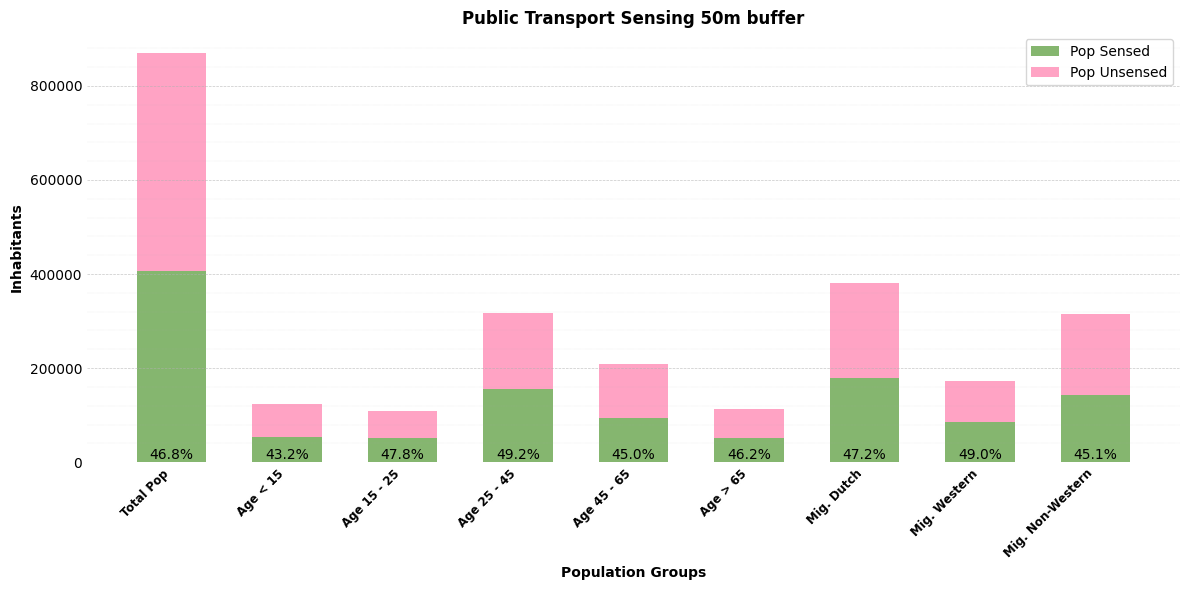

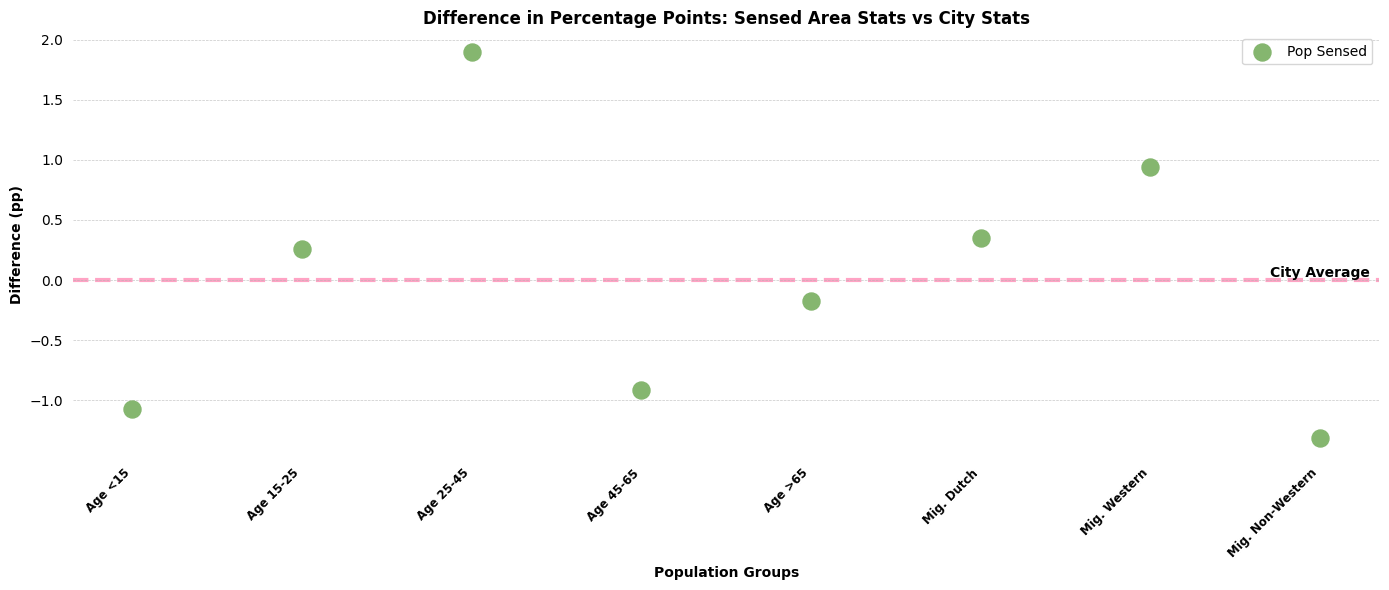

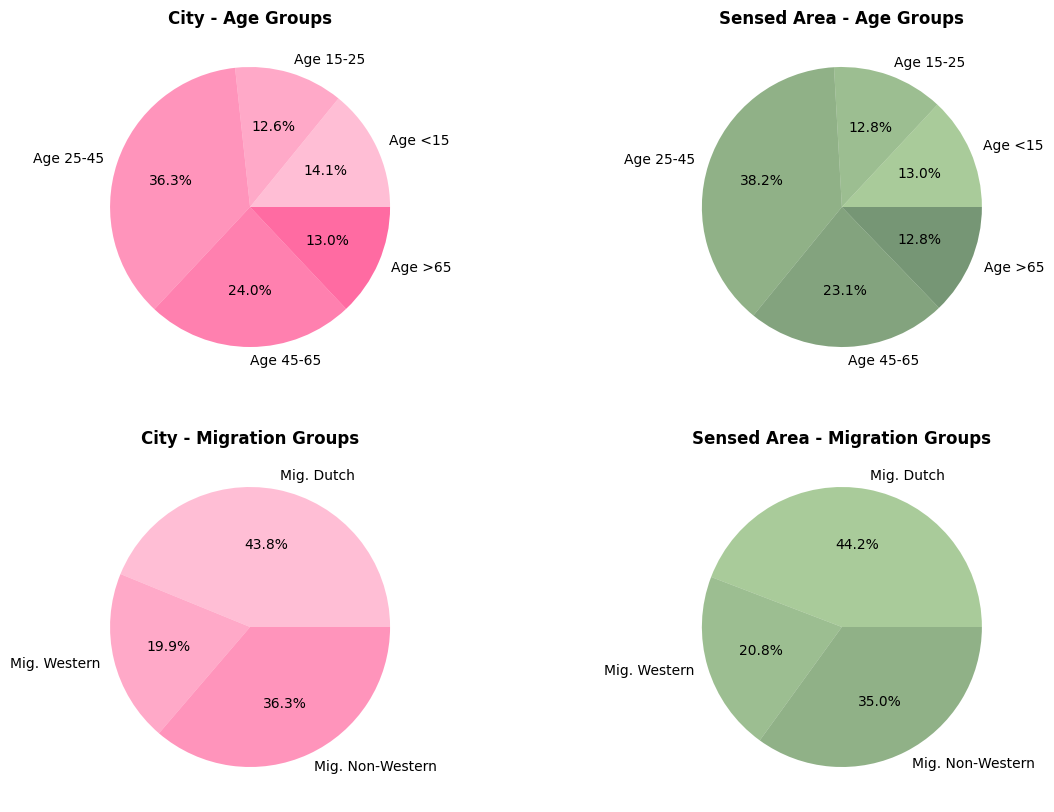

In [20]:

# Call analysis
sums_df, gdf_meters, cbs_gdf, gdf_projected, joined_gdf, average_stats = lines_analysis(transport_gdf, cbs_gdf)

# Call visualization
fig1, fig2, fig3, fig4 = lines_visualisation(gdf_projected, cbs_gdf, joined_gdf, ams_gdf, sums_df, average_stats)

# Add Stats for each LINE 
-lines average


- Lines
- Average Stats 
- Amsterdam Stats

Excluded was the concate with Amsterdam average - we will see later

In [21]:
def aggregate_line_stats(gdf_projected, transport_gdf, cbs_gdf, buffer_distance):
    lines_stats_list = []
    for route in gdf_projected['route_shor'].unique():
        _, _, _, _, _, stats = lines_analysis(
            transport_gdf,
            cbs_gdf,
            buffer_distance,
            line_number=route,
            transport_type=None
        )
        stats['route_shor'] = route
        lines_stats_list.append(stats)

    df = pd.concat(lines_stats_list, ignore_index=True)
    non_amsterdam = df[df['Area'] != 'Amsterdam']
    amsterdam_unique = df[df['Area'] == 'Amsterdam'].drop_duplicates()
    combined = pd.concat([non_amsterdam, amsterdam_unique], ignore_index=True)
    lines_stats_df  = combined[combined['Area'] == 'Sensed Area']
    lines_stats_df.to_csv('lines_stats_df.csv', index=False)
    return lines_stats_df 


#### Keep City Stats

### Concat City Stats and Lines Stats

In [22]:
def inhabitants_by_route(gdf_all, cbs_gdf, buffer_distance=50, crs='EPSG:28992'):
    """
    For each unique route_shor, calculate the number of inhabitants within the buffer.
    Returns a DataFrame with route_shor and inhabitants count.
    """
    results = []
    for route in gdf_all['route_shor'].unique():
        # Filter for this route
        line_gdf = gdf_all[gdf_all['route_shor'] == route]
        # Buffer
        line_buffer = line_gdf.to_crs(crs).copy()
        line_buffer['geometry'] = line_buffer['geometry'].buffer(buffer_distance)
        # Ensure CRS match
        cbs_proj = cbs_gdf.to_crs(crs)
        # Spatial join
        joined = gpd.sjoin(cbs_proj, line_buffer, how='inner', predicate='intersects')
        # Sum inhabitants
        inhabitants = joined['A_inhab'].sum()
        results.append({'route_shor': route, 'A_Inhab': inhabitants})
        inhabitants_line = pd.DataFrame(results)
        inhabitants_line.to_csv('inhabitants_line.csv', index=False)

    return inhabitants_line

In [23]:

def prepare_lines_average(lines_stats_df, city_stats_df, inhabitants_line, total_inhab = 870375): # for Amsterdam
    # concatenate and reorder
    df = pd.concat([lines_stats_df, city_stats_df], ignore_index=True)
    cols = ['route_shor'] + [c for c in df.columns if c not in ('route_shor','Area')] + ['Area']
    df = df[cols]
    df = pd.concat([df.tail(1), df.iloc[:-1]], ignore_index=True)
    df.at[0, 'route_shor'] = None

    # merge absolute inhabitants
    df = df.merge(inhabitants_line[['route_shor', 'A_Inhab']], on='route_shor', how='left')

    # export and return
    #df.to_csv('lines_stats_AMS_df.csv', index=False)

    # change first row route_shor == "AMSTERDAM"
    df.loc[0, 'route_shor'] = ''
    df.loc[0, 'A_Inhab'] = total_inhab


    lines_stats_AMS_df = df.copy()
    return lines_stats_AMS_df


## FUNCTION 3 | Lines Stats

In [24]:
def line_statistics_pipeline(gdf_projected, transport_gdf, cbs_gdf, buffer_distance=50, crs='EPSG:28992'):
    """
    Full pipeline to process line statistics:
    1. Aggregate line statistics.
    2. Extract city-level statistics.
    3. Calculate inhabitants per line.
    4. Prepare average line statistics.

    Parameters:
    - gdf_projected : filtered transport GeoDataFrame
    - transport_filepath : path to transport data file
    - cbs_filepath : path to CBS shapefile
    - buffer_distance : buffer size (default 50)
    - crs : coordinate reference system (default EPSG:28992)

    Returns:
    - lines_stats : final prepared average line statistics DataFrame
    """


    # Step 2: Aggregate line statistics
    lines_stats_df = aggregate_line_stats(
        gdf_projected,
        transport_gdf,
        cbs_gdf,
        buffer_distance
    )

    # Step 3: Calculate city-level stats
    average_stats = normalize_statistics(generate_summary_statistics(cbs_gdf))
    city_stats_df = average_stats.loc[average_stats.index == 0]

    # Step 4: Calculate inhabitants per line
    inhabitants_line = inhabitants_by_route(
        gdf_projected,
        cbs_gdf,
        buffer_distance=buffer_distance,
        crs=crs
    )

    # Step 5: Prepare average line statistics
    lines_stats = prepare_lines_average(
        lines_stats_df,
        city_stats_df,
        inhabitants_line
    )

    return lines_stats


In [25]:
# USAGE test
lines_average = line_statistics_pipeline(gdf_projected, transport_gdf, cbs_gdf, buffer_distance=50, crs='EPSG:28992')

In [27]:
lines_average.to_csv('lines_average_NEW.csv', index=False)